In [16]:
import pandas as pd
import numpy as np


In [17]:
df = pd.read_csv('/content/my_flie.csv')

In [18]:
# Assuming your data is in a DataFrame called 'df'
# Step 1: Find the top 5 most frequent customers
top_customers = df['customer_name'].value_counts().nlargest(5).index.tolist()

# Step 2: Create a list to store DataFrames for each customer
customer_dfs = []

# Step 3: For each top customer, create a pivot table
for customer in top_customers:
    # Filter data for this customer
    customer_data = df[df['customer_name'] == customer].copy()

    # Convert order_date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(customer_data['order_date']):
        customer_data['order_date'] = pd.to_datetime(customer_data['order_date'])

    # Create pivot table with date as index and products as columns
    pivot_df = customer_data.pivot_table(
        index='order_date',
        columns='item_name_clean',
        values='quantity',
        aggfunc='sum',
        fill_value=0
    )

    # Add customer information to the DataFrame for reference
    pivot_df.name = customer

    # Append to our list of customer DataFrames
    customer_dfs.append(pivot_df)

# Example of how to access the first customer's DataFrame
print(f"DataFrame for customer: {customer_dfs[0].name}")
print(customer_dfs[0].head())

DataFrame for customer: Ramesh Hotel
item_name_clean  adani mota besan  adani patla besan  \
order_date                                             
2024-10-01                      0                  0   
2024-10-03                      0                  0   
2024-10-04                      0                  0   
2024-10-05                      0                  0   
2024-10-06                      0                  0   

item_name_clean  bawarchi vanaspati pouch 1ltr  besan  chhola  \
order_date                                                      
2024-10-01                                   0      0       0   
2024-10-03                                   0      0       0   
2024-10-04                                   0      0       0   
2024-10-05                                   0      0       0   
2024-10-06                                   0      0       0   

item_name_clean  dalda vanaspati pouch  ganesh maida  independence steam rice  \
order_date                       

In [19]:
# Create a folder to store the CSV files (optional)
import os
if not os.path.exists('customer_data'):
    os.makedirs('customer_data')

# Save each customer DataFrame to a CSV file
for i, customer_df in enumerate(customer_dfs):
    customer_name = customer_df.name
    # Clean the customer name to ensure it's a valid filename
    clean_name = ''.join(c if c.isalnum() else '_' for c in customer_name)

    # Create a filename with the customer name
    filename = f'customer_data/customer_{i+1}_{clean_name}.csv'

    # Save to CSV
    customer_df.to_csv(filename)
    print(f"Saved data for {customer_name} to {filename}")

Saved data for Ramesh Hotel to customer_data/customer_1_Ramesh_Hotel.csv
Saved data for Viru k Mashoor samose aur bread pakaude to customer_data/customer_2_Viru_k_Mashoor_samose_aur_bread_pakaude.csv
Saved data for Dev Chole Bhature to customer_data/customer_3_Dev_Chole_Bhature.csv
Saved data for Krishna Puri Chola to customer_data/customer_4_Krishna_Puri_Chola.csv
Saved data for Aggarwal sweets to customer_data/customer_5_Aggarwal_sweets.csv


In [20]:
# Function for Croston forecasting
def croston(ts, alpha=0.4, horizon=14):
    # Initialize variables
    demand = ts[ts > 0]

    if len(demand) == 0:
        return pd.Series([0] * horizon)

    demand_intervals = pd.Series(demand.index).diff().dt.days.fillna(1)

    # Initialize values
    last_demand = demand.iloc[0]
    last_interval = demand_intervals.iloc[0]

    # Lists to store smoothed values
    smoothed_demand = [last_demand]
    smoothed_interval = [last_interval]

    # Apply Croston's method
    for i in range(1, len(demand)):
        # Update demand estimate
        last_demand = alpha * demand.iloc[i] + (1 - alpha) * last_demand
        smoothed_demand.append(last_demand)

        # Update interval estimate
        last_interval = alpha * demand_intervals.iloc[i] + (1 - alpha) * last_interval
        smoothed_interval.append(last_interval)

    # Calculate forecast (final smoothed demand / final smoothed interval)
    forecast_value = smoothed_demand[-1] / smoothed_interval[-1]

    # Generate forecast dates
    last_date = ts.index[-1]
    forecast_dates = [last_date + timedelta(days=i+1) for i in range(horizon)]

    # Create forecast series with the same value for the entire horizon
    forecast = pd.Series([forecast_value] * horizon, index=forecast_dates)

    return forecast

In [21]:
# Assuming customer_dfs[0] is the top customer's DataFrame
top_customer_df = customer_dfs[0]

# Get the latest date in the data
latest_date = top_customer_df.index.max()

# Create a dictionary to store forecasts for each product
forecasts = {}

In [23]:
from datetime import timedelta # Importing the timedelta object from datetime module
import pandas as pd

In [25]:
!pip install statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [107]:
# Generate forecasts for each product the customer has purchased
for product in top_customer_df.columns:
    # Get the time series for this product
    product_ts = top_customer_df[product]

    # Apply exponential smoothing for regular patterns or Croston for intermittent demand
    zero_ratio = (product_ts == 0).mean()

    if zero_ratio > 0.5:  # If more than 50% of values are zero, use Croston
        forecast = croston(product_ts, alpha=0.4, horizon=14)
    else:  # Otherwise use exponential smoothing
        model = ExponentialSmoothing(
            product_ts,
            trend='add',
            seasonal='add',
            seasonal_periods=7,  # Assuming weekly seasonality
            damped=True
        ).fit()

        forecast_dates = pd.date_range(
            start=latest_date + timedelta(days=1),
            periods=14
        )
        forecast = pd.Series(
            model.forecast(14).values,
            index=forecast_dates
        )

    # Round forecasts to nearest integer (can't order partial quantities)
    forecast = forecast.round().astype(int)

    # Store only non-zero forecasts
    if forecast.sum() >= 0:
        forecasts[product] = forecast

<ipython-input-107-b06cf49b3293>:12: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-107-b06cf49b3293>:12: FutureWarning: the 'damped' keyword is deprecated, use 'damped_tre

In [108]:
# Create a DataFrame with all forecasts
forecast_df = pd.DataFrame(forecasts)

# Fill NaN values with 0
forecast_df = forecast_df.fillna(0)

In [109]:
# Print summary of expected orders in next 14 days
print(f"Forecast for top customer: {top_customer_df.name}")
print("\nTotal quantities expected in next 14 days:")
print(forecast_df.sum())

# Save the forecast to CSV
forecast_df.to_csv(f'customer_data/top_customer_forecast_next_14days.csv')

print(f"\nDetailed daily forecast saved to 'customer_data/top_customer_forecast_next_14days.csv'")

Forecast for top customer: Ramesh Hotel

Total quantities expected in next 14 days:
adani mota besan                  28
bawarchi vanaspati pouch 1ltr     14
chhola                            56
ganesh maida                     126
kezar aata                        84
kezar maida                       42
kn gold maida                    112
nature fresh soya tin15l          14
normal sugar                      42
prakash aata                     112
rice moti gold steam              14
riceman jeera rice                42
shreshtha aata                   140
swastik maida                    140
tata salt pkt1kg                  14
independence steam rice            0
steam rice                         0
adani patla besan                  0
besan                              0
dalda vanaspati pouch              0
saccha heera chhola                0
soyum soya tin15l v                0
dtype: int64

Detailed daily forecast saved to 'customer_data/top_customer_forecast_next_14days.csv'


In [111]:
forecast_df.shape

(14, 22)

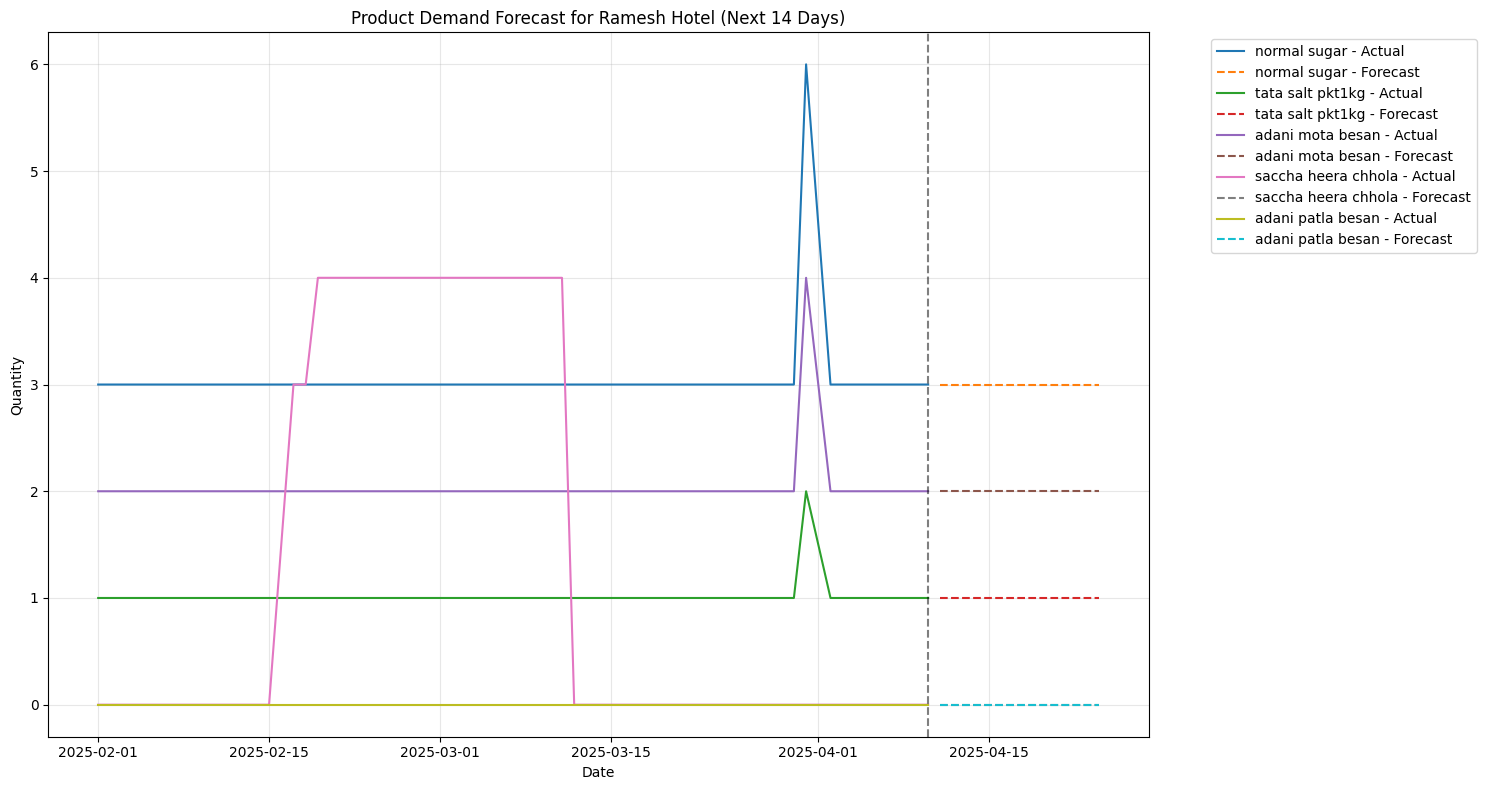

In [112]:
# Plot forecasts for top products from different demand patterns
def plot_forecasts(n_days=60):
    plt.figure(figsize=(15, 8))

    # Get the last date in historical data
    last_date = top_customer_df.index.max()

    # Select products with different demand patterns
    zero_ratios = (top_customer_df == 0).mean()

    # Classify products by demand pattern
    smooth = [p for p in top_customer_df.columns if zero_ratios[p] < 0.3][:2]
    intermittent = [p for p in top_customer_df.columns if 0.3 <= zero_ratios[p] < 0.7][:2]
    lumpy = [p for p in top_customer_df.columns if zero_ratios[p] >= 0.7][:1]

    # Combine products from different categories
    products_to_plot = smooth + intermittent + lumpy

    # Plot each product's historical and forecast data
    for product in products_to_plot:
        if product in forecast_df.columns:
            # Plot historical data (last n_days)
            historical = top_customer_df[product][-n_days:]
            plt.plot(historical.index, historical, label=f'{product} - Actual')

            # Plot forecast data
            plt.plot(forecast_df.index, forecast_df[product], '--', label=f'{product} - Forecast')

    # Add vertical line at forecast start
    plt.axvline(x=last_date, color='black', linestyle='--', alpha=0.5)

    # Add labels and formatting
    plt.title(f'Product Demand Forecast for {top_customer_df.name} (Next 14 Days)')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the plotting function
plot_forecasts()

In [113]:
X_train = top_customer_df.iloc[:-14]
X_test = top_customer_df.iloc[-14:]

In [114]:
X_test

item_name_clean,adani mota besan,adani patla besan,bawarchi vanaspati pouch 1ltr,besan,chhola,dalda vanaspati pouch,ganesh maida,independence steam rice,kezar aata,kezar maida,...,normal sugar,prakash aata,rice moti gold steam,riceman jeera rice,saccha heera chhola,shreshtha aata,soyum soya tin15l v,steam rice,swastik maida,tata salt pkt1kg
order_date,,,,,,,,,,,,,,,,,,,,,
2025-03-27,2,0,0,0,4,0,0,0,0,0,...,3,0,0,0,0,10,0,3,0,1
2025-03-28,2,0,0,0,4,0,0,0,0,0,...,3,0,0,0,0,10,0,3,0,1
2025-03-29,2,0,0,0,4,0,0,0,0,0,...,3,0,0,0,0,10,0,3,0,1
2025-03-30,2,0,0,0,4,0,0,0,0,0,...,3,0,0,0,0,10,0,3,0,1
2025-03-31,4,0,0,0,8,0,0,0,0,0,...,6,0,0,0,0,20,0,6,0,2
2025-04-02,2,0,0,0,4,0,0,0,0,0,...,3,0,0,0,0,10,0,3,0,1
2025-04-03,2,0,0,0,4,0,0,0,0,0,...,3,0,0,0,0,10,0,3,0,1
2025-04-04,2,0,0,0,4,0,0,3,0,0,...,3,0,0,0,0,10,0,0,0,1
2025-04-05,2,0,0,0,4,0,0,3,0,0,...,3,0,0,0,0,10,1,0,0,1


In [115]:
# Generate forecasts for each product the customer has purchased
for product in X_train.columns:
    # Get the time series for this product
    product_ts = X_train[product]

    # Apply exponential smoothing for regular patterns or Croston for intermittent demand
    zero_ratio = (product_ts == 0).mean()

    if zero_ratio > 0.5:  # If more than 50% of values are zero, use Croston
        forecast = croston(product_ts, alpha=0.4, horizon=14)
    else:  # Otherwise use exponential smoothing
        model = ExponentialSmoothing(
            product_ts,
            trend='add',
            seasonal='add',
            seasonal_periods=7,  # Assuming weekly seasonality
            damped=True
        ).fit()

        forecast_dates = pd.date_range(
            start=latest_date + timedelta(days=1),
            periods=14
        )
        forecast = pd.Series(
            model.forecast(14).values,
            index=forecast_dates
        )

    # Round forecasts to nearest integer (can't order partial quantities)
    forecast = forecast.round().astype(int)

    # Store only non-zero forecasts
    if forecast.sum() > 0:
        forecasts[product] = forecast

<ipython-input-115-2e600a4f82af>:12: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-115-2e600a4f82af>:12: FutureWarning: the 'damped' keyword is deprecated, use 'damped_tre

In [116]:
# Create a DataFrame with all forecasts
forecast_df = pd.DataFrame(forecasts)

# Fill NaN values with 0
forecast_df = forecast_df.fillna(0)

In [117]:
# Print summary of expected orders in next 14 days
print(f"Forecast for top customer: {top_customer_df.name}")
print("\nTotal quantities expected in next 14 days:")
print(forecast_df.sum())

# Save the forecast to CSV
forecast_df.to_csv(f'customer_data/top_customer_forecast_next_14days.csv')

print(f"\nDetailed daily forecast saved to 'customer_data/top_customer_forecast_next_14days.csv'")

Forecast for top customer: Ramesh Hotel

Total quantities expected in next 14 days:
adani mota besan                  28.0
bawarchi vanaspati pouch 1ltr     14.0
chhola                            56.0
ganesh maida                     126.0
kezar aata                        84.0
kezar maida                       42.0
kn gold maida                    112.0
nature fresh soya tin15l          14.0
normal sugar                      42.0
prakash aata                     112.0
rice moti gold steam              14.0
riceman jeera rice                42.0
shreshtha aata                   140.0
swastik maida                    140.0
tata salt pkt1kg                  14.0
independence steam rice           42.0
steam rice                        42.0
adani patla besan                  0.0
besan                              0.0
dalda vanaspati pouch              0.0
saccha heera chhola                0.0
soyum soya tin15l v                0.0
dtype: float64

Detailed daily forecast saved to 'customer